bertを使用

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib_venn import venn2

In [2]:
DATA = '~/art_compe/data/'
OUT_PUT = 'out_put/4/'
os.makedirs(OUT_PUT, exist_ok=True)

In [3]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from time import time

def decorate(s: str, decoration=None):
    if decoration is None:
        decoration = '★' * 20

    return ' '.join([decoration, str(s), decoration])

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' ', verbose=0):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
        self.verbose = verbose

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        if self.verbose is None:
            return
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [4]:
import inspect

def param_to_name(params: dict, key_sep='_', key_value_sep='=') -> str:
    """
    dict を `key=value` で連結した string に変換します.
    Args:
        params:
        key_sep:
            key 同士を連結する際に使う文字列.
        key_value_sep:
            それぞれの key / value を連結するのに使う文字列.
            `"="` が指定されると例えば { 'foo': 10 } は `"foo=10"` に変換されます.
    Returns:
        文字列化した dict
    """
    sorted_params = sorted(params.items())
    return key_sep.join(map(lambda x: key_value_sep.join(map(str, x)), sorted_params))


def cachable(function):
    attr_name = '__cachefile__'
    def wrapper(*args, **kwrgs):
        force = kwrgs.pop('force', False)
        call_args = inspect.getcallargs(function, *args, **kwrgs)

        arg_name = param_to_name(call_args)
        name = attr_name + arg_name

        use_cache = hasattr(function, name) and not force

        if use_cache:
            cache_object = getattr(function, name)
        else:
            print('run')
            cache_object = function(*args, **kwrgs)
            setattr(function, name, cache_object)

        return cache_object

    return wrapper

In [5]:
@cachable
def read_csv(name):
    if '.csv' not in name:
        name = name + '.csv'
        
    return pd.read_csv(os.path.join(DATA, name))

In [6]:
class AbstractBaseBlock:
    def fit(self, all_df:pd.DataFrame, input_df:pd.DataFrame, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df:pd.DataFrame):
        return NotImplementedError()

In [7]:
class NumericBlock(AbstractBaseBlock):
    def transform(self, input_df):
        use_columns = [
            'dating_period',
            'dating_year_early',
            'dating_year_late'
        ]
        
        return input_df[use_columns].copy()

In [8]:
class StringLengthBlock(AbstractBaseBlock):
    def __init__(self, column):
        self.column = column
        
    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].str.len()
        return out_df.add_prefix('StringLength_')

In [9]:
class CountEncodingBlock(AbstractBaseBlock):
    def __init__(self, column: str):
        self.column = column
        
    def fit(self, all_df, input_df, y=None):
        vc = all_df[self.column].value_counts()
        self.count_ = vc
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].map(self.count_)
        return out_df.add_prefix('CE_')

In [10]:
class OneHotEncoding(AbstractBaseBlock):
    def __init__(self, column, min_count=30):
        self.column = column
        self.min_count = min_count
        
    def fit(self, all_df, input_df, y=None):
        vc = all_df[self.column].value_counts()
        self.categories = vc[vc > self.min_count].index
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.DataFrame()
        cat = pd.Categorical(input_df[self.column], categories=self.categories)
        out_df = pd.get_dummies(cat)
        out_df.columns = out_df.columns.tolist()
        return out_df.add_prefix(f'{self.column}=')

In [11]:
def run_blocks(all_df, input_df, blocks, y=None, test=False):
    out_df = pd.DataFrame()
    
    print(decorate('start run blocks...'))
    
    with Timer(prefix='run test={}'.format(test)):
        for block in blocks:
            with Timer(prefix='\t={}'.format(str(block))):
                if not test:
                    out_i = block.fit(all_df, input_df, y=y)
                else:
                    out_i = block.transform(input_df)
                    
            assert len(input_df) == len(out_i), block
            name = block.__class__.__name__
            out_df = pd.concat([out_df, out_i.add_suffix(f'@{name}')], axis=1)
            
    return out_df

In [12]:
OBJECT_ID = 'object_id'
def left_join(left, right, on=OBJECT_ID):
    if isinstance(left, pd.DataFrame):
        left = left[on]
    return pd.merge(left, right, on=on, how='left').drop(columns=[on])

class HistoricalPersonBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count
        
    def fit(self, all_df, input_df, y=None):
        person_df = read_csv('historical_person')
        vc = person_df['name'].value_counts()
        use_name = vc[vc>self.min_count].index
        idx = person_df['name'].isin(use_name)
        _use_df = person_df[idx].reset_index(drop=True)
        
        self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'HistricalPersonBlock_name')

In [13]:
#テキスト処理で必要
import texthero as hero
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

In [14]:
def text_nomalization(text):
    
    # 英語とオランダ語を stopword として指定
    custom_stopwords = nltk.corpus.stopwords.words('dutch') + nltk.corpus.stopwords.words('english')

    x = hero.clean(text, pipeline=[
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
    ])

    return x

class TfidfBlock(AbstractBaseBlock):
    def __init__(self, column:str):
        self.column = column
        
    def preprocess(self, input_df):
        x = text_nomalization(input_df[self.column])
        return x
    
    def get_master(self, input_df):
        return input_df
    
    def fit(self, all_df, input_df, y=None):
        master_df = self.get_master(input_df)
        text = self.preprocess(input_df)
        self.pipeline_ = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=10000)),
            ('svd', TruncatedSVD(n_components=50)),
        ])
        
        self.pipeline_.fit(text)
        return self.transform(input_df)
    
    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pipeline_.transform(text)
        
        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'{self.column}_tfidf_')

In [15]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from typing import Union, Optional, Iterable

def fit_lgbm(X: np.ndarray, 
             y: np.ndarray, 
             cv: Iterable, 
             y_max: Optional[float] = None,
             params: Optional[dict] = None, 
             verbose: Optional[int] =50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}
    is_silent = verbose is None
    is_cut_y = y_max is not None

    models = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(y, dtype=np.float)
    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        # 最大値が決まっている場合, 学習するデータだけ丸めを行なう
        if is_cut_y:
            idx_use = y_train < y_max
            y_train = np.where(idx_use, y_train, y_max)
        clf = lgbm.LGBMRegressor(**params)

        with Timer(prefix='fit fold={} '.format(i), verbose=verbose):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        if not is_silent:
            print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')

    if not is_silent:
        score = mean_squared_error(y, oof_pred) ** .5
        print('Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'rmse', 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .1,

    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5, 

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': 71,
}

In [35]:
train_df = read_csv('train')
test_df = read_csv('test')
all_df = pd.concat([train_df, test_df], ignore_index=True)

In [36]:
feature_blocks = [
    # count encoding
    *[CountEncodingBlock(c) for c in [
        'art_series_id', 
        'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late',]],

    # 文字列長さ
    *[StringLengthBlock(c) for c in [
        'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
    ]],
    # historical person
    HistoricalPersonBlock(),

    # description の tfidf
    *[TfidfBlock(c) for c in [
        'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 
    ]],
]

In [37]:
train_feat_df = run_blocks(all_df, train_df, blocks=feature_blocks, test=False)

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	=<__main__.CountEncodingBlock object at 0x7f72f9952250> 0.022[s]
	=<__main__.CountEncodingBlock object at 0x7f72f9952790> 0.017[s]
	=<__main__.CountEncodingBlock object at 0x7f7328c986d0> 0.015[s]
	=<__main__.CountEncodingBlock object at 0x7f7328c98220> 0.016[s]
	=<__main__.CountEncodingBlock object at 0x7f72f80e30a0> 0.007[s]
	=<__main__.CountEncodingBlock object at 0x7f72f80e3100> 0.007[s]
	=<__main__.CountEncodingBlock object at 0x7f72f04922e0> 0.013[s]
	=<__main__.CountEncodingBlock object at 0x7f72f0492880> 0.006[s]
	=<__main__.CountEncodingBlock object at 0x7f72f04927c0> 0.014[s]
	=<__main__.CountEncodingBlock object at 0x7f72f04926d0> 0.005[s]
	=<__main__.CountEncodingBlock object at 0x7f72f04927f0> 0.005[s]
	=<__main__.CountEncodingBlock object at 0x7f72f0492790> 0.005[s]
	=<__main__.CountEncodingBlock object at 0x7f72f0492340> 0.006[s]
	=<__main__.CountEncodingBlock object at 0x7f72f0492670> 0.003[s]
	=<__main__.Co

/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


	=<__main__.TfidfBlock object at 0x7f72f04921c0> 1.572[s]


/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


	=<__main__.TfidfBlock object at 0x7f72f0492730> 3.041[s]


/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


	=<__main__.TfidfBlock object at 0x7f72f0492910> 2.331[s]


/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


	=<__main__.TfidfBlock object at 0x7f72f04929a0> 0.824[s]


/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


	=<__main__.TfidfBlock object at 0x7f72f0492a60> 0.822[s]


/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


	=<__main__.TfidfBlock object at 0x7f7328d19ca0> 1.238[s]


/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


	=<__main__.TfidfBlock object at 0x7f7328d19c10> 0.409[s]


/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


	=<__main__.TfidfBlock object at 0x7f72fa6dac40> 2.251[s]
run test=False 12.924[s]


In [19]:
!pip install transformers > /dev/null

In [20]:
# transformers というライブラリに入ってる BERT を使用します

import pandas as pd
import numpy as np
import torch
import transformers

from transformers import BertTokenizer
from tqdm import tqdm
tqdm.pandas()


class BertSequenceVectorizer:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = 'bert-base-multilingual-uncased'#'bert-base-uncased'
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [29]:
BSV = BertSequenceVectorizer() # インスタンス化します

train_bert_df = pd.DataFrame()
train_df['sub_title'] = text_nomalization(train_df['sub_title'])
train_df['sub_title'] = train_df['sub_title'].fillna("NaN") # null は代わりのもので埋めます
train_bert_df['sub_title_feature'] = train_df['sub_title'].progress_apply(lambda x: BSV.vectorize(x))

/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
100%|██████████| 12026/12026 [13:52<00:00, 14.44it/s]


In [30]:
train_bert = pd.DataFrame()
for i in tqdm(range(len(train_bert_df['sub_title_feature']))):
    can_df = pd.DataFrame(train_bert_df['sub_title_feature'][i])
    train_bert = pd.concat([train_bert, can_df], axis=1)
    
train_bert.T

100%|██████████| 12026/12026 [02:28<00:00, 80.73it/s]


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.067987,-0.067907,0.121613,-0.020944,-0.319161,-0.002181,-0.148772,-0.074068,-1.864210,-0.027331,...,0.008655,2.083570,-0.109909,-0.149025,0.114424,0.059286,-0.107781,-0.077560,-0.036231,-0.068810
0,-0.050257,-0.034117,0.077266,-0.038357,-0.304385,0.000900,-0.123064,-0.008224,-1.934797,-0.035571,...,0.044489,2.142897,-0.175309,-0.080205,0.094376,0.016757,-0.117582,-0.016018,-0.090871,-0.056534
0,-0.022823,-0.018996,0.081923,-0.045281,-0.293532,0.031727,-0.138781,-0.023200,-1.920318,-0.061726,...,0.024663,2.135845,-0.185213,-0.093093,0.081878,0.015240,-0.119653,-0.007514,-0.085464,-0.001920
0,-0.058623,-0.054660,0.107128,-0.000377,-0.309310,0.012843,-0.163101,-0.073848,-1.899014,-0.020853,...,0.039225,2.126905,-0.114619,-0.153514,0.094808,0.043080,-0.106299,-0.064086,-0.047168,-0.102221
0,-0.072126,-0.057035,0.103876,-0.003239,-0.333812,0.023574,-0.168316,-0.057686,-1.863953,-0.019924,...,0.012208,2.121623,-0.118187,-0.161328,0.096998,0.025450,-0.130265,-0.060859,-0.073079,-0.076030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.047552,-0.009569,0.073688,-0.049997,-0.308911,0.029073,-0.116335,-0.015854,-1.924902,-0.027519,...,0.037330,2.147639,-0.177984,-0.082008,0.091200,0.031465,-0.118394,-0.021090,-0.074772,-0.035883
0,-0.054653,-0.040634,0.061749,-0.043711,-0.303068,-0.007903,-0.132132,-0.014562,-1.936205,-0.028579,...,0.067662,2.123123,-0.181619,-0.084820,0.078342,0.031650,-0.116961,-0.015536,-0.096025,-0.060378
0,-0.060074,-0.041079,0.080014,-0.047745,-0.306995,0.006156,-0.127111,-0.023831,-1.935784,-0.039696,...,0.070973,2.123229,-0.186361,-0.086160,0.087148,0.019002,-0.118641,-0.018068,-0.081453,-0.047848
0,-0.061840,-0.012691,0.070239,-0.032603,-0.304167,0.017020,-0.116301,-0.017280,-1.939006,-0.020555,...,0.059096,2.123606,-0.174192,-0.076833,0.087161,0.029964,-0.119347,-0.031904,-0.089898,-0.044844


In [31]:
tt = train_bert.T
tt = tt.reset_index()
tt = tt.drop(columns='index')

In [38]:
tt

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.067987,-0.067907,0.121613,-0.020944,-0.319161,-0.002181,-0.148772,-0.074068,-1.864210,-0.027331,...,0.008655,2.083570,-0.109909,-0.149025,0.114424,0.059286,-0.107781,-0.077560,-0.036231,-0.068810
1,-0.050257,-0.034117,0.077266,-0.038357,-0.304385,0.000900,-0.123064,-0.008224,-1.934797,-0.035571,...,0.044489,2.142897,-0.175309,-0.080205,0.094376,0.016757,-0.117582,-0.016018,-0.090871,-0.056534
2,-0.022823,-0.018996,0.081923,-0.045281,-0.293532,0.031727,-0.138781,-0.023200,-1.920318,-0.061726,...,0.024663,2.135845,-0.185213,-0.093093,0.081878,0.015240,-0.119653,-0.007514,-0.085464,-0.001920
3,-0.058623,-0.054660,0.107128,-0.000377,-0.309310,0.012843,-0.163101,-0.073848,-1.899014,-0.020853,...,0.039225,2.126905,-0.114619,-0.153514,0.094808,0.043080,-0.106299,-0.064086,-0.047168,-0.102221
4,-0.072126,-0.057035,0.103876,-0.003239,-0.333812,0.023574,-0.168316,-0.057686,-1.863953,-0.019924,...,0.012208,2.121623,-0.118187,-0.161328,0.096998,0.025450,-0.130265,-0.060859,-0.073079,-0.076030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,-0.047552,-0.009569,0.073688,-0.049997,-0.308911,0.029073,-0.116335,-0.015854,-1.924902,-0.027519,...,0.037330,2.147639,-0.177984,-0.082008,0.091200,0.031465,-0.118394,-0.021090,-0.074772,-0.035883
12022,-0.054653,-0.040634,0.061749,-0.043711,-0.303068,-0.007903,-0.132132,-0.014562,-1.936205,-0.028579,...,0.067662,2.123123,-0.181619,-0.084820,0.078342,0.031650,-0.116961,-0.015536,-0.096025,-0.060378
12023,-0.060074,-0.041079,0.080014,-0.047745,-0.306995,0.006156,-0.127111,-0.023831,-1.935784,-0.039696,...,0.070973,2.123229,-0.186361,-0.086160,0.087148,0.019002,-0.118641,-0.018068,-0.081453,-0.047848
12024,-0.061840,-0.012691,0.070239,-0.032603,-0.304167,0.017020,-0.116301,-0.017280,-1.939006,-0.020555,...,0.059096,2.123606,-0.174192,-0.076833,0.087161,0.029964,-0.119347,-0.031904,-0.089898,-0.044844


In [42]:
train_feat_df = tt#pd.concat([train_feat_df, tt], axis=1)
train_feat_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.067987,-0.067907,0.121613,-0.020944,-0.319161,-0.002181,-0.148772,-0.074068,-1.864210,-0.027331,...,0.008655,2.083570,-0.109909,-0.149025,0.114424,0.059286,-0.107781,-0.077560,-0.036231,-0.068810
1,-0.050257,-0.034117,0.077266,-0.038357,-0.304385,0.000900,-0.123064,-0.008224,-1.934797,-0.035571,...,0.044489,2.142897,-0.175309,-0.080205,0.094376,0.016757,-0.117582,-0.016018,-0.090871,-0.056534
2,-0.022823,-0.018996,0.081923,-0.045281,-0.293532,0.031727,-0.138781,-0.023200,-1.920318,-0.061726,...,0.024663,2.135845,-0.185213,-0.093093,0.081878,0.015240,-0.119653,-0.007514,-0.085464,-0.001920
3,-0.058623,-0.054660,0.107128,-0.000377,-0.309310,0.012843,-0.163101,-0.073848,-1.899014,-0.020853,...,0.039225,2.126905,-0.114619,-0.153514,0.094808,0.043080,-0.106299,-0.064086,-0.047168,-0.102221
4,-0.072126,-0.057035,0.103876,-0.003239,-0.333812,0.023574,-0.168316,-0.057686,-1.863953,-0.019924,...,0.012208,2.121623,-0.118187,-0.161328,0.096998,0.025450,-0.130265,-0.060859,-0.073079,-0.076030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,-0.047552,-0.009569,0.073688,-0.049997,-0.308911,0.029073,-0.116335,-0.015854,-1.924902,-0.027519,...,0.037330,2.147639,-0.177984,-0.082008,0.091200,0.031465,-0.118394,-0.021090,-0.074772,-0.035883
12022,-0.054653,-0.040634,0.061749,-0.043711,-0.303068,-0.007903,-0.132132,-0.014562,-1.936205,-0.028579,...,0.067662,2.123123,-0.181619,-0.084820,0.078342,0.031650,-0.116961,-0.015536,-0.096025,-0.060378
12023,-0.060074,-0.041079,0.080014,-0.047745,-0.306995,0.006156,-0.127111,-0.023831,-1.935784,-0.039696,...,0.070973,2.123229,-0.186361,-0.086160,0.087148,0.019002,-0.118641,-0.018068,-0.081453,-0.047848
12024,-0.061840,-0.012691,0.070239,-0.032603,-0.304167,0.017020,-0.116301,-0.017280,-1.939006,-0.020555,...,0.059096,2.123606,-0.174192,-0.076833,0.087161,0.029964,-0.119347,-0.031904,-0.089898,-0.044844


In [43]:
#ligthgbm 
y = train_df['likes'].values
y = np.log1p(y)
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

print(decorate('start training'))
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
print(decorate('FINISHED'))

★★★★★★★★★★★★★★★★★★★★ start training ★★★★★★★★★★★★★★★★★★★★
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	valid_0's rmse: 1.22414
fit fold=0  1.431[s]
Fold 0 RMSLE: 1.2241
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's rmse: 1.25798
fit fold=1  1.166[s]
Fold 1 RMSLE: 1.2580
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's rmse: 1.22175
fit fold=2  1.119[s]
Fold 2 RMSLE: 1.2217
[LightGBM] [Warning] Accuracy may be bad since y

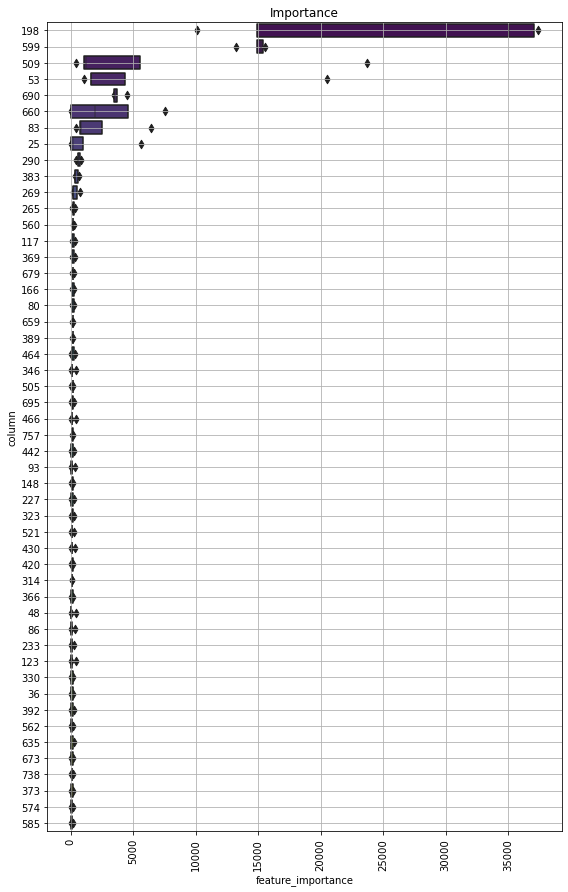

In [44]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_feat_df)